In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d engraqeel/iot23preprocesseddata

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/engraqeel/iot23preprocesseddata
License(s): unknown
100% 183M/183M [00:07<00:00, 32.7MB/s]
100% 183M/183M [00:07<00:00, 26.6MB/s]


In [2]:
import zipfile
import os
import pandas as pd
import re

zip_file_path = "/content/iot23preprocesseddata.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

folder_path = '/content/extracted_files'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

combined_df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    combined_df = pd.concat([combined_df, df], ignore_index=True)


print("number of categories:", len(set(combined_df['label'])))
print("categories:", set(combined_df['label']))
print("category count:", combined_df['label'].value_counts())

<ipython-input-2-73e91054fde2>:18: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


number of categories: 13
categories: {'C&C-HeartBeat-FileDownload', 'C&C', 'Attack', 'C&C-Torii', 'C&C-FileDownload', 'FileDownload', 'Okiru', 'C&C-Mirai', 'PartOfAHorizontalPortScan', 'C&C-HeartBeat', 'Benign', 'Okiru-Attack', 'DDoS'}
category count: label
PartOfAHorizontalPortScan     3389036
Okiru                         1313012
Benign                         688812
DDoS                           638506
C&C                             15286
C&C-HeartBeat                    1332
Attack                            538
C&C-FileDownload                   46
C&C-Torii                          30
FileDownload                       13
C&C-HeartBeat-FileDownload          8
Okiru-Attack                        3
C&C-Mirai                           1
Name: count, dtype: int64


In [3]:
class_mapping = {
    'DDoS': 'DDoS',
    'Benign': 'Benign',
    'PartOfAHorizontalPortScan': 'PortScan',
    'Okiru': 'Okiru',
    'C&C-HeartBeat': 'C&C',
    'C&C': 'C&C',
    'C&C-Mirai': 'C&C',
    'C&C-Torii': 'C&C',
    'C&C-PartOfAHorizontalPortScan': 'C&C',
    'C&C-FileDownload': 'C&C',
    'C&C-HeartBeat-FileDownload': 'C&C',
    'Okiru-Attack': 'Okiru',
}

combined_df['merged_label'] = combined_df['label'].map(class_mapping)

combined_df = combined_df.dropna(subset=['merged_label'])

merged_category_counts = combined_df['merged_label'].value_counts()

print("Counts of merged categories:")
print(merged_category_counts)


Counts of merged categories:
merged_label
PortScan    3389036
Okiru       1313015
Benign       688812
DDoS         638506
C&C           16703
Name: count, dtype: int64


In [4]:
combined_df.describe()

,Unnamed: 0,ts,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06,6.046072e+06
mean,2.481269e+05,1.546218e+09,3.603472e+04,1.897729e+04,5.018928e-02,4.375867e+01,1.907419e+03,5.796292e-02,6.369185e+01
std,1.453386e+05,9.546425e+06,1.776951e+04,2.273152e+04,2.104297e+01,3.534379e+04,1.392853e+06,9.775121e+01,1.422849e+05
min,0.000000e+00,1.532101e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.220840e+05,1.537539e+09,2.256800e+04,2.300000e+01,0.000000e+00,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
50%,2.480550e+05,1.545426e+09,3.618200e+04,8.081000e+03,0.000000e+00,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
75%,3.740250e+05,1.551383e+09,5.083800e+04,3.721500e+04,0.000000e+00,2.000000e+00,8.000000e+01,0.000000e+00,0.000000e+00
max,4.999980e+05,1.569018e+09,6.553500e+04,6.549000e+04,2.027200e+04,6.602735e+07,1.914793e+09,2.394840e+05,3.496187e+08


In [5]:
print(combined_df['merged_label'].isnull().sum())


0


In [6]:
from sklearn.utils import resample

df_benign = combined_df[combined_df['merged_label'] == 'Benign']
df_ddos = combined_df[combined_df['merged_label'] == 'DDoS']
df_portscan = combined_df[combined_df['merged_label'] == 'PortScan']
df_cnc = combined_df[combined_df['merged_label'] == 'C&C']
df_okiru = combined_df[combined_df['merged_label'] == 'Okiru']

min_samples = 16000
df_ddos_downsampled = resample(df_ddos, replace=False, n_samples=min_samples, random_state=42)
df_portscan_downsampled = resample(df_portscan, replace=False, n_samples=min_samples, random_state=42)
df_cnc_downsampled = resample(df_cnc, replace=False, n_samples=min_samples, random_state=42)
df_okiru_downsampled = resample(df_okiru, replace=False, n_samples=min_samples, random_state=42)
df_benign_downsampled = resample(df_benign, replace=False, n_samples=min_samples, random_state=42)

balanced_df = pd.concat([ df_benign_downsampled, df_ddos_downsampled, df_portscan_downsampled,
                         df_cnc_downsampled, df_okiru_downsampled])
merged_category_counts = balanced_df['merged_label'].value_counts()

print("Counts of merged categories:")
print(merged_category_counts)


Counts of merged categories:
merged_label
Benign      16000
DDoS        16000
PortScan    16000
C&C         16000
Okiru       16000
Name: count, dtype: int64


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import pandas as pd


features = balanced_df.drop(columns=['label', 'merged_label'])  # Drop label columns from features
labels = balanced_df['merged_label']

categorical_columns = features.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column].astype(str))  # Convert to string before encoding
    label_encoders[column] = le

features = features.dropna(axis=1)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

n_estimators = 100  # Number of trees
rf = RandomForestClassifier(n_estimators=1, warm_start=True, random_state=42, n_jobs=-1)

for i in tqdm(range(1, n_estimators + 1), desc="Building Trees"):
    rf.set_params(n_estimators=i)
    rf.fit(scaled_features, encoded_labels)

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_18_features = feature_importance_df.head(18)['Feature'].values

selected_features_df = pd.DataFrame(scaled_features, columns=features.columns)[top_18_features]
final_data = pd.concat([selected_features_df, pd.DataFrame(encoded_labels, columns=['encoded_label'])], axis=1)

top_18_features, final_data.head(), label_mapping


Building Trees: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


(array(['id.resp_p', 'ts', 'orig_ip_bytes', 'id.orig_h', 'Unnamed: 0',
        'id.orig_p', 'orig_pkts', 'id.resp_h', 'conn_state', 'history',
        'duration', 'orig_bytes', 'resp_bytes', 'resp_pkts', 'proto',
        'service', 'resp_ip_bytes', 'uid'], dtype=object),
    id.resp_p        ts  orig_ip_bytes  id.orig_h  Unnamed: 0  id.orig_p  \
 0  -0.898858 -0.091571      -0.003978  -0.616079    0.409689   0.616996   
 1  -0.898858 -0.091661      -0.003864  -0.616079   -0.204026   0.034825   
 2  -0.898858 -0.091718      -0.003978  -0.616079   -0.594067   0.187159   
 3  -0.898858 -0.091801      -0.003978  -0.616079   -1.163873   0.406820   
 4  -0.898858 -0.091603      -0.003978  -0.616079    0.192516  -0.116104   
 
    orig_pkts  id.resp_h  conn_state   history  duration  orig_bytes  \
 0  -0.003695  -1.619064    0.382335  0.023601 -0.516599   -0.187693   
 1  -0.003640   0.532437    0.382335  0.023601  1.873243   -0.099908   
 2  -0.003695   2.211121    0.382335  0.023601 -0.5165

In [ ]:
final_data.shape

(80000, 19)

In [ ]:
print(final_data.describe())

          id.resp_p            ts  orig_ip_bytes     id.orig_h    Unnamed: 0  \
count  8.000000e+04  8.000000e+04   8.000000e+04  8.000000e+04  8.000000e+04   
mean  -2.273737e-17 -1.807621e-14  -5.329071e-19 -1.023182e-16 -3.410605e-17   
std    1.000006e+00  1.000006e+00   1.000006e+00  1.000006e+00  1.000006e+00   
min   -8.997844e-01 -1.251143e+00  -4.034694e-03 -9.243680e+00 -1.262747e+00   
25%   -8.988576e-01 -8.915362e-01  -3.996708e-03 -9.036657e-01 -1.039099e+00   
50%   -6.311148e-01 -9.157353e-02  -3.977715e-03 -3.284923e-01 -7.821262e-02   
75%    5.999218e-01  5.995981e-02  -3.958722e-03  1.109441e+00  8.833015e-01   
max    1.709459e+00  1.966302e+00   2.807845e+02  8.586695e+00  1.835555e+00   

          id.orig_p     orig_pkts     id.resp_h    conn_state       history  \
count  8.000000e+04  8.000000e+04  8.000000e+04  8.000000e+04  8.000000e+04   
mean   4.547474e-17 -2.664535e-19 -1.222134e-16 -1.421085e-16 -4.121148e-17   
std    1.000006e+00  1.000006e+00  1.00000

In [ ]:
print(final_data['encoded_label'].value_counts())


encoded_label
0    16000
2    16000
4    16000
1    16000
3    16000
Name: count, dtype: int64


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min

# Assuming 'final_data' contains the data with 18 selected features

# Step 1: Extract features and labels from final_data using column names
features = final_data.drop(columns=['encoded_label'])  # Drop the label column to get the features
labels = final_data['encoded_label']  # Encoded labels

# Step 2: Scale features into RGB range [0, 255]
scaler = MinMaxScaler(feature_range=(0, 255))
scaled_features = scaler.fit_transform(features)

# Step 3: Perform Agglomerative Clustering on scaled features
# Divide 18 features into 6 clusters for a 2x3 grid (3 features per cluster for R, G, B)
agg_cluster = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')
cluster_labels = agg_cluster.fit_predict(scaled_features.T)  # Transpose for clustering features

# Step 4: Find Centroids and 3 Closest Features for Each Cluster
cluster_centroids = []
cluster_indices = []

for cluster_idx in range(6):
    # Get the features in this cluster
    cluster_features = scaled_features.T[cluster_labels == cluster_idx]

    # Calculate the centroid of the cluster
    cluster_centroid = np.mean(cluster_features, axis=0)  # Already a NumPy array

    # Find the 3 closest features to the centroid
    closest_indices, _ = pairwise_distances_argmin_min(
        cluster_features, cluster_centroid.reshape(1, -1)
    )

    # Get the indices of the top 3 closest features
    closest_3 = closest_indices[:3] if len(closest_indices) >= 3 else np.pad(closest_indices, (0, 3 - len(closest_indices)), constant_values=-1)
    cluster_indices.append(closest_3)

# Step 5: Create the RGB Pixels for 2x3 Grid
image_dataset = []
image_labels = []

for i in range(scaled_features.shape[0]):
    feature_row = scaled_features[i, :]
    rgb_image = np.zeros((2, 3, 3))  # Initialize 2x3 RGB image

    for cluster_idx, feature_indices in enumerate(cluster_indices):
        x = cluster_idx // 3  # Row index in 2x3 grid
        y = cluster_idx % 3   # Column index in 2x3 grid

        # Assign the values of the 3 features to R, G, B channels
        for channel, feature_index in enumerate(feature_indices):
            if feature_index != -1:  # Ensure valid indices
                rgb_image[x, y, channel] = feature_row[feature_index]

    image_dataset.append(rgb_image)
    image_labels.append(labels.iloc[i])

# Step 6: Convert the dataset to numpy arrays
image_dataset = np.array(image_dataset)
image_labels = np.array(image_labels)

# Step 7: Print the dataset shapes
print(f"Image dataset shape: {image_dataset.shape}")
print(f"Label dataset shape: {image_labels.shape}")


Image dataset shape: (80000, 2, 3, 3)
Label dataset shape: (80000,)


In [ ]:
print(len(set(image_labels)))
print(set(image_labels))
print(label_mapping)

5
{0, 1, 2, 3, 4}
{'Benign': 0, 'C&C': 1, 'DDoS': 2, 'Okiru': 3, 'PortScan': 4}


In [ ]:
# image_labels is a pandas Series
label_counts = pd.Series(image_labels).value_counts()

# Print the counts for each category
print(label_counts)

0    16000
2    16000
4    16000
1    16000
3    16000
Name: count, dtype: int64


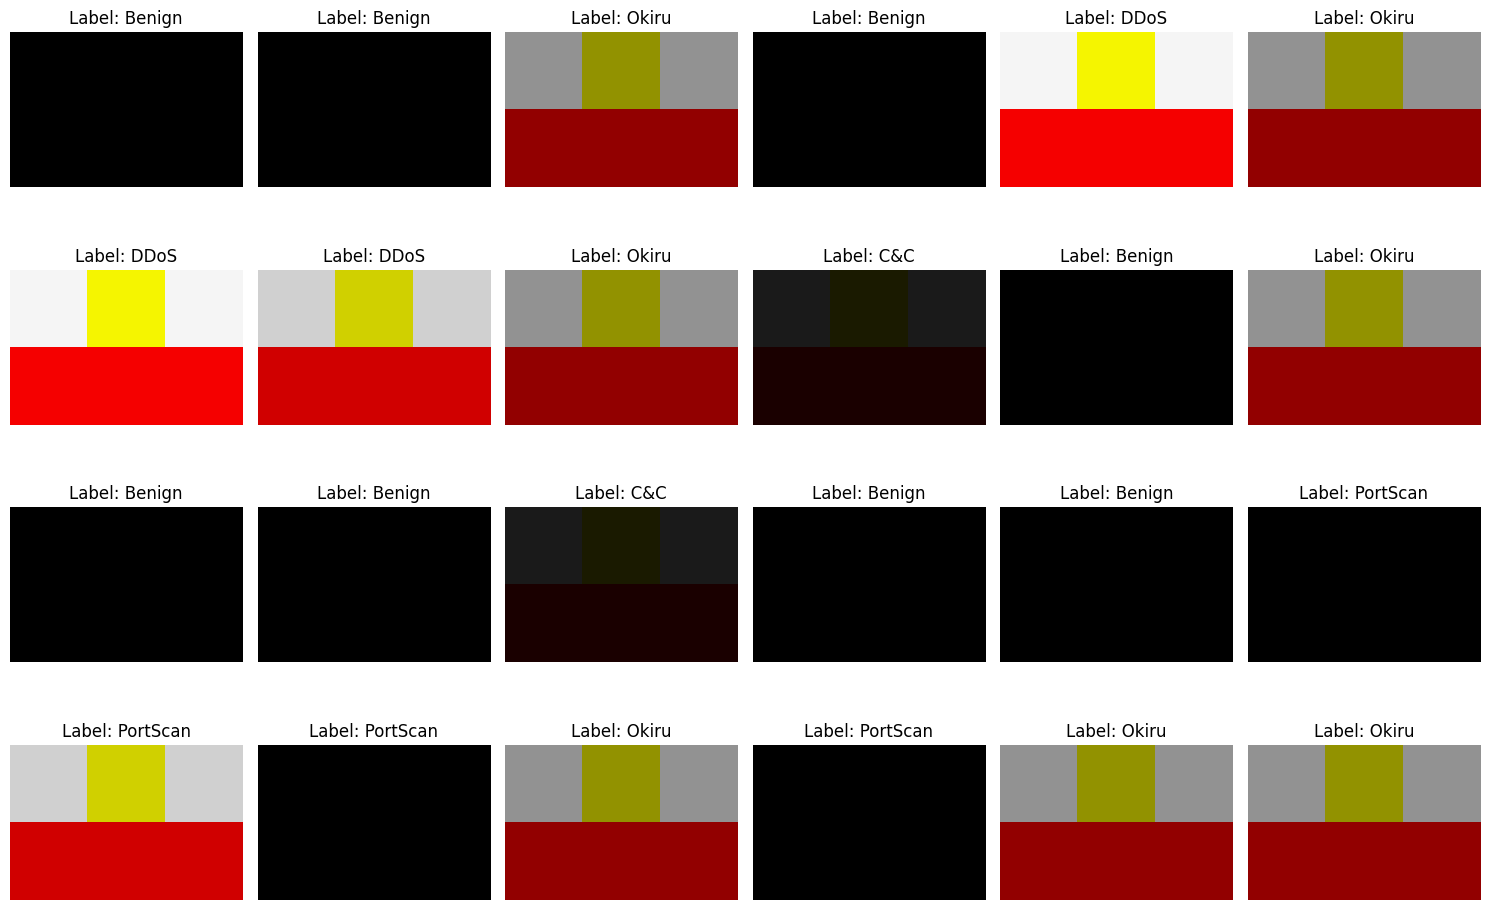

In [ ]:
import matplotlib.pyplot as plt

# Function to display 24 random images with their labels
def show_random_images(image_dataset, image_labels, categories, num_samples=24):
    # Randomly select 'num_samples' images
    indices = np.random.choice(len(image_dataset), num_samples, replace=False)
    selected_images = image_dataset[indices]
    selected_labels = image_labels[indices]

    # Create a figure with a grid of 4 rows and 6 columns (with the last column partially filled)
    fig, axes = plt.subplots(4, 6, figsize=(15, 10))

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Loop through the selected images and display them
    for i in range(num_samples):
        img = selected_images[i]
        label = selected_labels[i]

        # Display the image and its corresponding label
        axes[i].imshow(img.astype(np.uint8))  # Convert to uint8 for display
        axes[i].set_title(f'Label: {categories[label]}')
        axes[i].axis('off')  # Turn off the axis for a cleaner display

    # Turn off remaining axes (if any)
    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming `label_mapping` contains the mapping from label integers to category names
categories = {v: k for k, v in label_mapping.items()}

# Call the function to display 22 random image samples with labels
show_random_images(image_dataset, image_labels, categories)

Using GPU: []
Training set: X_train: (48000, 2, 3, 3), y_train: (48000,)
Validation set: X_val: (24000, 2, 3, 3), y_val: (24000,)
Test set: X_test: (8000, 2, 3, 3), y_test: (8000,)

Training Autoencoder...
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 10381.8682 - val_loss: 10431.8457
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 10378.7715 - val_loss: 10431.8457
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 10368.8643 - val_loss: 10431.8457
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 10387.7510 - val_loss: 10431.8457
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 10384.4180 - val_loss: 10431.8457
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 10387.1953 - val_loss: 10431.8457
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 10374.7373 - val_loss: 10431.8457
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 10365.6006 - val_loss: 10431.8457
Epoch 9/20
1500/150

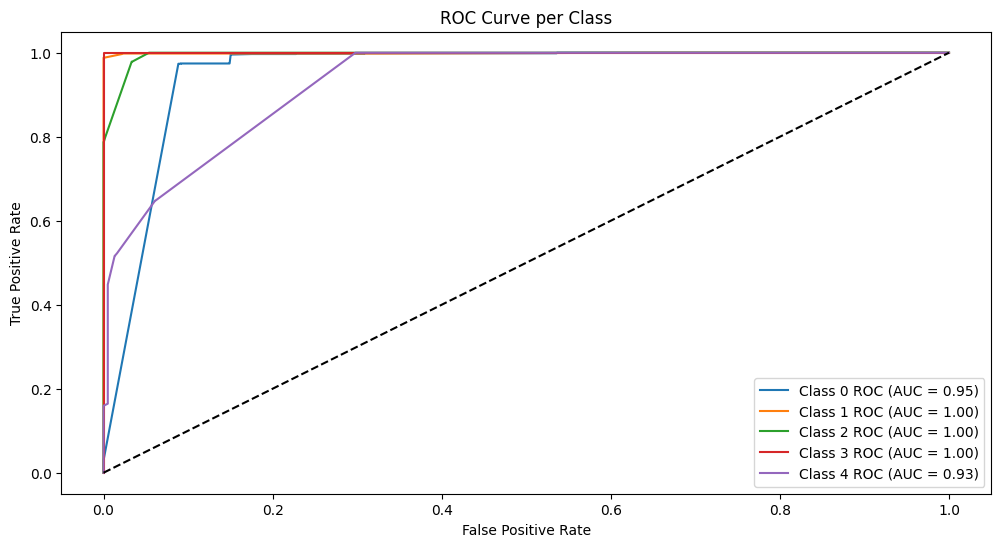

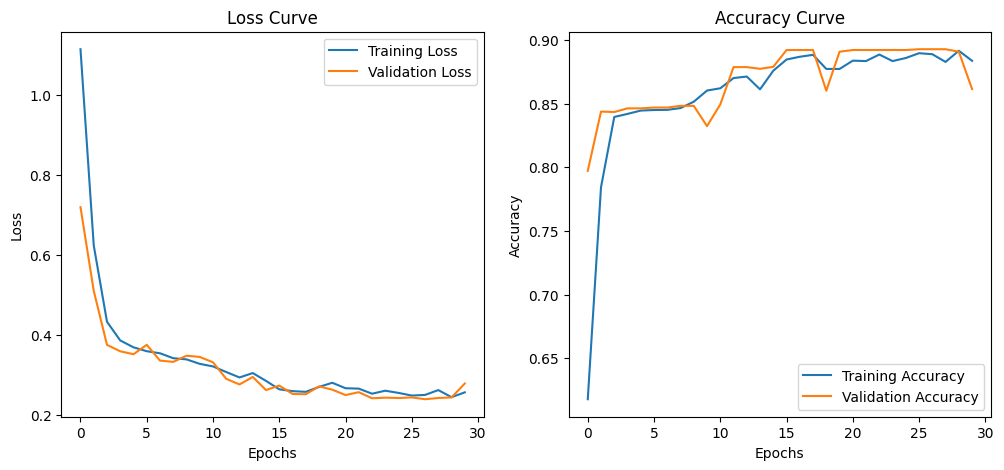

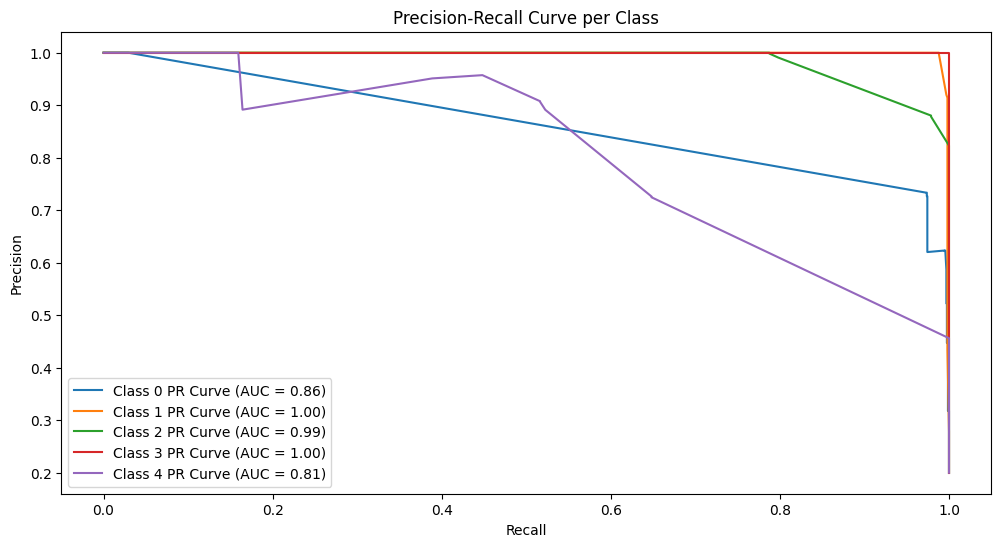

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm

# Use GPU if available
print("Using GPU:", tf.config.list_physical_devices('GPU'))

# Assuming 'image_dataset' (2x3x3 RGB images) and 'image_labels' (encoded labels) are prepared as per your data pipeline
X = image_dataset
y = image_labels

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Verify shapes
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Autoencoder Architecture with Convolutional Layers
def create_autoencoder(input_shape):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded_output = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Latent space representation

    # Decoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_output)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Same size output as input

    # Autoencoder Model
    autoencoder = models.Model(encoder_input, decoder_output, name="Autoencoder")
    encoder = models.Model(encoder_input, encoded_output, name="Encoder")

    return autoencoder, encoder

# Classifier Architecture using the encoder output
def create_classifier(encoder):
    # Use the encoder output as input to the classifier
    classifier_input = encoder.output
    x = layers.Flatten()(classifier_input)
    x = layers.Dense(64, activation='relu')(x)
    classifier_output = layers.Dense(len(np.unique(y)), activation='softmax')(x)

    # Full Model
    classifier = models.Model(encoder.input, classifier_output, name="Classifier")
    return classifier

# Initialize Models
input_shape = X_train.shape[1:]  # (2, 3, 3)
autoencoder, encoder = create_autoencoder(input_shape)
classifier = create_classifier(encoder)

# Compile Models
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='mse')
classifier.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Data Pipelines
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset_auto = tf.data.Dataset.from_tensor_slices((X_val, X_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset_cls = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset_cls = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Autoencoder
print("\nTraining Autoencoder...")
autoencoder.fit(train_dataset, validation_data=val_dataset_auto, epochs=20, verbose=1)

# Fine-tune Classifier
print("\nFine-tuning Classifier...")
history = classifier.fit(train_dataset_cls, validation_data=val_dataset_cls, epochs=30, verbose=1, callbacks=[early_stopping])

# Evaluation on the test set
y_pred_prob = classifier.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in range(len(np.unique(y)))])
print("\nClassification Report:\n", class_report)

# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nPrecision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# ROC and AUC Curves for each class
plt.figure(figsize=(12, 6))
for i in range(len(np.unique(y))):  # For each class
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} ROC (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend()
plt.show()

# Loss and Accuracy Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# Precision-Recall Curve for each class
plt.figure(figsize=(12, 6))
for i in range(len(np.unique(y))):
    precision, recall, _ = precision_recall_curve((y_test == i).astype(int), y_pred_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} PR Curve (AUC = {auc(recall, precision):.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Class")
plt.legend()
plt.show()
